# Project : Identify fraud from Enron Email

## Project Overview 

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial datas of top enron executives. 

The Enron datasets comprising emails and financial datas of Enron were made available for public for research and analysis and can be downloaded from : https://www.cs.cmu.edu/~./enron/.

![](Enron-1.jpg)

### Goal of the project
The goal of this project is to use the machine learning skills to build a POI(person of interest) identifier based on financial and email data made public as a result of the Enron scandal. The POI is an acronym for 'person of interest' i.e., a person who is charged by the law for commiting a crime, in this case the scandal at Enron.  

The overall work done for this project can be divided into four parts :
   1.  __Exploring the Enron Dataset__  
       This involves data cleaning, outlier removal and analyzing.

   2.  __Feature processing of the Enron dataset__  
       It includes feature creation, feature scaling, feature selection and feature transform.
      
   3.  __Choosing the algorithm__   
       As the dataset given has labelled data and output expected is also discrete so supervised learning techniques are used in this project. The supervised learning algorithms are tuned to achieve the best performance on the test dataset. 
       
   4. __Evaluation__  
      This step involves validation followed by overall performance check of the project done using evaluation metrics such as precision, recall and f1_score.


In [2]:
# importing required functions and modules
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.grid_search import GridSearchCV
from time import time

import pandas as pd
from matplotlib import pyplot as plt


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### 1. Exploring the Enron Dataset

The pickled Enron data is loaded as a pandas dataframe for easy anlysis of the dataset. And the key i.e., the Enron employees name is used as the index of the pandas dataframe.

In [3]:
# Converting the given pickled Enron data to a pandas dataframe
enron_df = pd.DataFrame.from_records(list(data_dict.values()))

# set the index of df to be the employees series:
employees = pd.Series(list(data_dict.keys()))
enron_df.set_index(employees, inplace=True)
enron_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [4]:
print "Size of the enron dataframe : ",enron_df.shape

Size of the enron dataframe :  (146, 21)


In [5]:
print "Number of data points(people) in the dataset : ",len(enron_df)

Number of data points(people) in the dataset :  146


In [6]:
print "To find the number of Features in the Enron Dataset : ",len(enron_df.columns)

To find the number of Features in the Enron Dataset :  21


In [7]:
# Counting the number of POIs and non-POIs in the given dataset
poi_count = enron_df.groupby('poi').size()
print "Total number of POI's in the given dataset : ",poi_count.iloc[1]
print "Total number of non-POI's in the given dataset : ",poi_count.iloc[0]

Total number of POI's in the given dataset :  18
Total number of non-POI's in the given dataset :  128


When you load the data into the dataframe, the data types are strings (or, in pandas, objects).

In [8]:
enron_df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                            bool
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object

Converting the datatypes in the given pandas dataframe into floating points for analysis and replace NaN with zeros.

In [9]:
# Coerce numeric values into floats or ints; also change NaN to zero:
enron_df_new = enron_df.apply(lambda x : pd.to_numeric(x, errors = 'coerce')).copy().fillna(0)
enron_df_new.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,...,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,...,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,...,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,...,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0


Removing the column of email_address from the enron_df as it is not of much used in this project.

In [10]:
# Dropping column 'email_address' as not required in analysis
enron_df_new.drop('email_address', axis = 1, inplace = True)

# Checking the changed shape of df
enron_df_new.shape

(146, 20)

### Outlier Investigation and Analyzing the features of Enron Dataset

#### Financial Features : Bonus and Salary
Drawing scatterplot of Bonus vs Salary of Enron employees

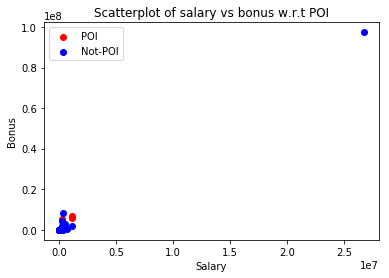

In [11]:
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == True],enron_df_new['bonus'][enron_df_new['poi'] == True], color = 'r',
           label = 'POI')
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == False],enron_df_new['bonus'][enron_df_new['poi'] == False],color = 'b',
           label = 'Not-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary vs bonus w.r.t POI")
plt.legend(loc='upper left')
plt.show() 

From the above figure, one point has very high value of salary and bonus. Checking for the concerned point.

In [12]:
# Finding the non-POI employee having maximum salary
enron_df_new['salary'].argmax()

'TOTAL'

#### Removing Outlier 1 : 'TOTAL'
The 'TOTAL' row corresponding to the outlier is removed from the enron dataframe. And again the scatterplot is drawn for bonus vs salary.

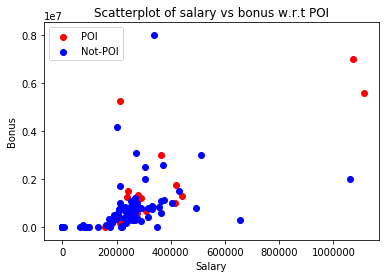

In [13]:
# Deleting the row 'Total' from the 
enron_df_new.drop('TOTAL', axis = 0, inplace = True)

# Drawing scatterplot with the modified dataframe
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == True],enron_df_new['bonus'][enron_df_new['poi'] == True], color = 'r',
           label = 'POI')
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == False],enron_df_new['bonus'][enron_df_new['poi'] == False],color = 'b',
           label = 'Not-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary vs bonus w.r.t POI")
plt.legend(loc='upper left')
plt.show() 

From the above figure, its observed that the data becomes more spread out and more comprehensable after the outlier removal. Its also observed that values of bonuses of POIs are higher than that of non-POIs.

As the POI's were taking larger amounts of money as bonus, in addition to their high salary so it can be stated that the ratio of bonus to salary of the POI's will be higher as compared to that of non-POI's. So i create a new feature called __ bonus-to-salary_ratio__ hoping that it may aid in the POI identification in the later parts of this project.

#### Feature created 1 : bonus-to-salary_ratio

In [14]:
# Created a new feature
enron_df_new['bonus-to-salary_ratio'] = enron_df_new['bonus']/enron_df_new['salary']

#### Removing Outlier 2 : 'THE TRAVEL AGENCY IN THE PARK'

From the _enron61702insiderpay.pdf_ provided by findlaw.com, a dataset was observed named 'THE TRAVEL AGENCY IN THE PARK'.
From the documentary [Enron The Smartest Guys In The Room](https://www.youtube.com/watch?v=H2f7FunDuTU) i had learnt that Enron had made up some transactions with bogus companies and  people so on observing the features of this dataset it can be considered as an outlier with very low values in all features except in _others_ and _total-payments_ and i am removing it.

In [15]:
# Features of the index 'THE TRAVEL AGENCY IN THE PARK'
enron_df_new.loc['THE TRAVEL AGENCY IN THE PARK']

bonus                             0
deferral_payments                 0
deferred_income                   0
director_fees                     0
exercised_stock_options           0
expenses                          0
from_messages                     0
from_poi_to_this_person           0
from_this_person_to_poi           0
loan_advances                     0
long_term_incentive               0
other                        362096
poi                           False
restricted_stock                  0
restricted_stock_deferred         0
salary                            0
shared_receipt_with_poi           0
to_messages                       0
total_payments               362096
total_stock_value                 0
bonus-to-salary_ratio           NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [16]:
# Deleting the row with index 'THE TRAVEL AGENCY IN THE PARK'
enron_df_new.drop('THE TRAVEL AGENCY IN THE PARK', axis = 0, inplace = True)

#### Financial Features : Deferred_income, deferred_payment and total_payment 

According to [BusinessDictionary.com](http://www.businessdictionary.com/definition/deferred-payment.html) : Deferred payment is "a loan arrangement in which the borrower is allowed to start making payments at some specified time in the future. Deferred payment arrangements are often used in retail settings where a person buys and receives an item with a commitment to begin making payments at a future date."

[Deferred income](https://en.wikipedia.org/wiki/Deferred_income) : (also known as deferred revenue, unearned revenue, or unearned income) is, in accrual accounting, money received for goods or services which have not yet been delivered. According to the revenue recognition principle, it is recorded as a liability until delivery is made, at which time it is converted into revenue.

As Enron scam involved a lot of undisclosed assets and cheating public by selling assets to shell companies at end of each month and buying them back at the start of next month to hide the acounting losses so there are chances that lot of deferred revenue by the company was used by the POI's.

In [17]:
enron_df_new['deferred_income'].describe()

count    1.440000e+02
mean    -1.936833e+05
std      6.060111e+05
min     -3.504386e+06
25%     -3.708600e+04
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: deferred_income, dtype: float64

The __deferred_income__ feature has mostly negative values as it is the money which has to be returned by the company.

In [18]:
# Finding out the integer index locations of POIs and non-POIs
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

print "length poi list : ",len(poi_rs)
print "length non-poi list : ",len(non_poi_rs)

length poi list :  18
length non-poi list :  126


Drawing scatterplot of Employees with deferred income

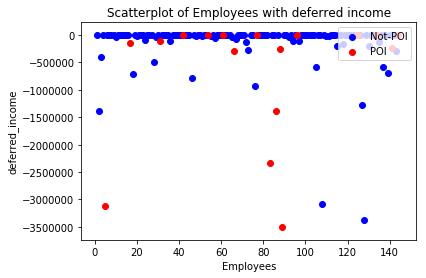

In [19]:
plt.scatter(non_poi_rs,
            enron_df_new['deferred_income'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['deferred_income'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('Employees')
plt.ylabel('deferred_income')
plt.title("Scatterplot of Employees with deferred income")
plt.legend(loc='upper right')
plt.show()

The above scatterplot is not much helpful in either detecting outliers or finding patterns as some POIs as well as non-POIs have high values of deferred income.   

Creating a scatterplot of total_payments vs deferral_payments w.r.t POI.

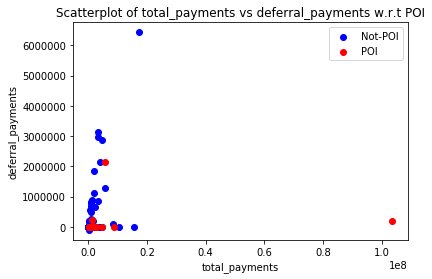

In [20]:
# scatterplot of total_payments vs deferral_payments w.r.t POI
plt.scatter(enron_df_new['total_payments'][enron_df_new['poi'] == False],
            enron_df_new['deferral_payments'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['total_payments'][enron_df_new['poi'] == True],
            enron_df_new['deferral_payments'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('total_payments')
plt.ylabel('deferral_payments')
plt.title("Scatterplot of total_payments vs deferral_payments w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

From the above scatterplot it can be observed that majority of POIs have very low value of deferral payments as compared to the deferral_payments of non-POIs.  
From the above we can observe there are two outliers. The one having high value of total_payments is a POI and the other outlier with high value of deferral payments is a non-POI. I am removing the non-POI outlier.

In [21]:
# Finding the non-POI employee having maximum 'deferral_payments'
enron_df_new['deferral_payments'].argmax()

'FREVERT MARK A'

#### Removing Outlier 3 : 'FREVERT MARK A'

In [22]:
# Removing the non-POI employee having maximum 'deferral_payments'
enron_df_new.drop('FREVERT MARK A', axis = 0, inplace = True)

#### Financial Features : 'long_term_incentive'

Making a scatterplot to check the long_term_incentive of different Enron employees.

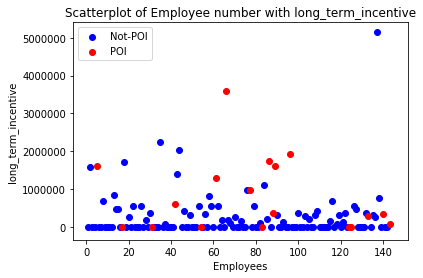

In [23]:
# Finding out the integer index locations of POIs and non-POIs
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

# Making a scatterplot
plt.scatter(non_poi_rs,
            enron_df_new['long_term_incentive'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['long_term_incentive'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('Employees')
plt.ylabel('long_term_incentive')
plt.title("Scatterplot of Employee number with long_term_incentive")
plt.legend(loc='upper left')
plt.show()

From figure, one employee has a very high value of __long_term_incentive__. So considering this point as an outlier and removing it.  

In [24]:
enron_df_new['long_term_incentive'].argmax()

'MARTIN AMANDA K'

#### Removing Outlier 4 : 'MARTIN AMANDA K'

In [25]:
enron_df_new.drop('MARTIN AMANDA K', axis = 0, inplace = True)

#### Financial Features : restricted_stock and restricted_stock_deferred

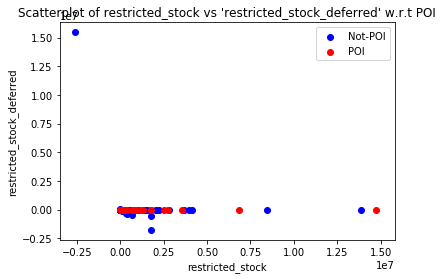

In [26]:
# Scatterplot of restricted_stock vs 'restricted_stock_deferred' w.r.t POI

plt.scatter(enron_df_new['restricted_stock'][enron_df_new['poi'] == False],
            enron_df_new['restricted_stock_deferred'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['restricted_stock'][enron_df_new['poi'] == True],
            enron_df_new['restricted_stock_deferred'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('restricted_stock')
plt.ylabel('restricted_stock_deferred')
plt.title("Scatterplot of restricted_stock vs 'restricted_stock_deferred' w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

In [27]:
enron_df_new['restricted_stock_deferred'].argmax()

'BHATNAGAR SANJAY'

So obtained an outlier in the feature __restricted_stock_deferred__. Also taking a quick look at the values of __restricted_stock_deferred__ most of the values are zeros and the remaining few are negative values. The outlier found here is for the enron employee __BHATNAGAR SANJAY__ who is not a POI and in this analysis i am removing this datapoint hoping that it may aid in classification.  

And at the other axis of the graph, the other maximum values are of a POI and a non-POI so no need to remove them. 

#### Removing Outlier 5 : 'BHATNAGAR SANJAY'

In [28]:
enron_df_new.drop('BHATNAGAR SANJAY', axis = 0, inplace = True)

#### Email Features :  from_poi_to_this_person and from_this_person_to_poi

Also it can be thought that for doing such a big scam the POI's might have frequent contact between them via E-mails so by checking on the number of e-mails transferred between POIs and an Employee we can be able to guess for the involvement of that person in that scam. So finding the relationship using the mail from and to this person with respect to the POI.

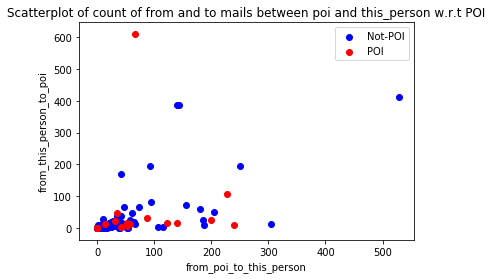

In [29]:
plt.scatter(enron_df_new['from_poi_to_this_person'][enron_df_new['poi'] == False],
            enron_df_new['from_this_person_to_poi'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['from_poi_to_this_person'][enron_df_new['poi'] == True],
            enron_df_new['from_this_person_to_poi'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('from_poi_to_this_person')
plt.ylabel('from_this_person_to_poi')
plt.title("Scatterplot of count of from and to mails between poi and this_person w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

This scatterplot shows relationship between the count of mails send to and fro among different employees of Enron. I think a different feature showing the proportion of mail sent by employees to and fro to the POI will be more helpful in finding out the POI. As POIs will have more communications with POIs as compared to communication with other non-POIS.   
So creating two new features.  

#### Features created : fraction_mail_from_poi and fraction_mail_to_poi

In [30]:
enron_df_new['fraction_mail_from_poi'] = enron_df_new['from_poi_to_this_person']/enron_df_new['from_messages'] 
enron_df_new['fraction_mail_to_poi'] = enron_df_new['from_this_person_to_poi']/enron_df_new['to_messages']

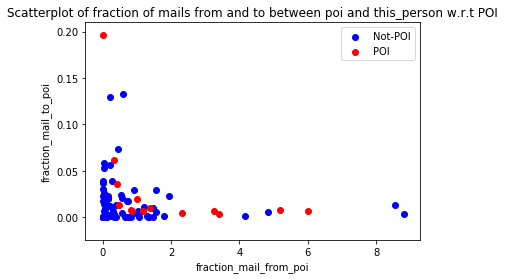

In [31]:
# Scatterplot of fraction of mails from and to between poi and this_person w.r.t POI
plt.scatter(enron_df_new['fraction_mail_from_poi'][enron_df_new['poi'] == False],
            enron_df_new['fraction_mail_to_poi'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['fraction_mail_from_poi'][enron_df_new['poi'] == True],
            enron_df_new['fraction_mail_to_poi'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('fraction_mail_from_poi')
plt.ylabel('fraction_mail_to_poi')
plt.title("Scatterplot of fraction of mails from and to between poi and this_person w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

From the above figure, the difference between POIs and non-POIs points can be clearly classified.  As the red dots representing POIs are more distinct, have higher values and are more seperate from the non-POI blue points.

In [32]:
#clean all 'inf' values which we got if the person's from_messages = 0
enron_df_new = enron_df_new.replace('inf', 0)
enron_df_new = enron_df_new.fillna(0)
# Converting the above modified dataframe to a dictionary
enron_dict = enron_df_new.to_dict('index')
print "Features of modified data_dictionary :"
print "Total number of datapoints : ",len(enron_dict)
print "Total number of features : ",len(enron_dict['METTS MARK'])

Features of modified data_dictionary :
Total number of datapoints :  141
Total number of features :  23


In [33]:
# Store to my_dataset for easy export below.
my_dataset = enron_dict

#### Features choosen by me to be used in the POI identifier

Out of the all features available to be me (given and created by me), i will be using 24 of them for the POI identification and feature processing. The given features can be divided into two types : financial features and email features.  
  - __17 financial features :__ 
  ['salary', 'bonus', 'long_term_incentive', 'bonus-to-salary_ratio', 'expenses','restricted_stock_deferred', 'restricted_stock', 'deferred_income','total_payments','other','shared_receipt_with_poi', 'loan_advances', 'director_fees', 'exercised_stock_options', 'deferral_payments', 'total_stock_value', 'restricted_stock']
                
  - __6 Email features :__ ['fraction_mail_from_poi', 'fraction_mail_to_poi', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 'from_messages']
  - __POI__
  

In [34]:
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'bonus-to-salary_ratio', 'deferral_payments', 'expenses', 
                 'restricted_stock_deferred', 'restricted_stock', 'deferred_income','fraction_mail_from_poi', 'total_payments',
                 'other', 'fraction_mail_to_poi', 'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 
                 'from_messages', 'shared_receipt_with_poi', 'loan_advances', 'director_fees', 'exercised_stock_options',
                'total_stock_value', 'restricted_stock']

In [35]:
# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### 2. Feature processing of the Enron dataset

Steps involved :  
__1. Feature scaling :__ though standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. Standardization involves rescaling the features such that they have the properties of a standard normal distribution with a mean of zero and a standard deviation of one. Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.  

In this project i will be using __MinMaxScaler__ which scales features to lie between zero and one. MinMaxScaler transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, i.e. between zero and one.  

In this project i have used feature scaling only for thise algorithms that use distance metrics (eg : KNN) in order to avoid loss of information.


__2. Feature Selection :__ feature selection/dimensionality reduction on sample sets is essential to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets. Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator.   

In this project i will be using __SelectKBest__ function to find the K best or high-scoring features. Objects of these function take as input a scoring function that returns univariate scores and p-values. Here __f_classif__ is used as scoring function. The f_classif function computes the ANOVA F-value between labels and features for classification tasks.  


__3. Dimensionality Reduction using PCA :__ PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, PCA is implemented as a transformer object that learns n components in its fit method, and can be used on new data to project it on these components.  

While doing this project i tried each algorithm using with and without PCA, after doing the feature selction. But i observed that after doing PCA the values of precision, recall and f1-score decreases by a large amount probably because of the loss of a large amount of important information which could have been used by the classifer for fitting. So i did not use it.  


__Pipeline__ is used to sequentially apply feature processing steps such as scaling, selection and classifcation.

Machine learning aims to obtain the parameter values that gives the optimal performance. Sklearn's __GridSearchCV__ module automates this process by performing a grid search over a range of parameter values for an estimator.

__StratifiedShuffleSplit__ is used as the cross-validation method. 

While choosing the algorithms to be used in this project, i have set the parameter n_split of StratifiedShuffleSplit as 100, to reduce runtime. 

In [36]:
### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, 
                                                                                             random_state=42)

# Stratified ShuffleSplit cross-validator
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.3,random_state = 42)

# Importing modules for feature scaling and selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Defining features to be used via the pipeline
## 1. Feature scaling
scaler = MinMaxScaler()

## 2. Feature Selection
skb = SelectKBest(f_classif)

## 3. PCA
pca = PCA()

### 3. Choosing Algorithm

For this project i used the following algorithms : 

1. Decision Tree classifier
2. KNN classifier
3. Gaussian Naive Bayes (GaussianNB) classifier


#### Tuning the Algorithm 
Tuning the algorithm for machine learning means to choose the best parameter values for algorithm that provides an optimized performance. If not tuned correctly the decision boundary made using the algorithm and training set data won't be able to correctly give the best prediction for test set data as chances of having high bias and high variance occurs.

__Grid search__ is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. 

For feature scaling i have used the SelectKBest algorithm and to tune this section of feature processing to get best performance i used different values for __k (Number of top features to select)__.   

In addition to this i also gave different values to the __ n_components__ parameter of PCA. It selects the number of components to keep i.e., after getting the features deemed as important by SelectKBest. But using PCA here has lead to decrese in value of precision, recall and f1 score.  


__Parameters tuned for Decision Tree classifier : __
 
 - criterion : The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.  
 - min_samples_split : The minimum number of samples required to split an internal node.
 
__Parameters tuned for KNN classifier : __

- n_neighbors : Number of neighbors to be used in the classifer. 

In [38]:
## Classifier 1 : Decision Tree classifier

from sklearn.tree import DecisionTreeClassifier
clf_dtree = DecisionTreeClassifier()

pipeline = Pipeline(steps = [("SKB", skb), ("dtree",clf_dtree)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],
              "dtree__criterion": ["gini", "entropy"],
              "dtree__min_samples_split": [2, 4, 8, 10]}


grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
#clf = clf.fit(features_train, labels_train)
grid.fit(features, labels)
print "training time: ", round(time()-t0, 3), "s"

# best algorithm
clf = grid.best_estimator_

t0 = time()
# refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

print "Accuracy of DT classifer is  : ",accuracy_score(labels_test, prediction)
print "Precision of DT classifer is : ",precision_score(prediction, labels_test)
print "Recall of DT classifer is    : ",recall_score(prediction, labels_test)
print "f1-score of DT classifer is  : ",f1_score(prediction, labels_test)

training time:  88.047 s
testing time:  0.0 s
Accuracy of DT classifer is  :  0.833333333333
Precision of DT classifer is :  0.333333333333
Recall of DT classifer is    :  0.4
f1-score of DT classifer is  :  0.363636363636


In [39]:
## Classifier 2 : KNN classifier

from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3,random_state = 42)
pipeline = Pipeline(steps = [("scaling", scaler), ("SKB", skb),  ("knn",clf_knn)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15, 16, 17, 18], 
              "knn__n_neighbors": [3,4,5,6,7,8,9,11,12,13,15],
              }

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
#clf = clf.fit(features_train, labels_train)
grid.fit(features, labels)
print "training time: ", round(time()-t0, 3), "s"

# best algorithm
clf = grid.best_estimator_

t0 = time()
# refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

print "Accuracy of DT classifer is  : ",accuracy_score(labels_test, prediction)
print "Precision of DT classifer is : ",precision_score(prediction, labels_test)
print "Recall of DT classifer is    : ",recall_score(prediction, labels_test)
print "f1-score of DT classifer is  : ",f1_score(prediction, labels_test)

training time:  12.584 s
testing time:  0.0 s
Accuracy of DT classifer is  :  0.880952380952
Precision of DT classifer is :  0.333333333333
Recall of DT classifer is    :  0.666666666667
f1-score of DT classifer is  :  0.444444444444


In [43]:
# Classifier  4 : Gaussian Naive Bayes (GaussianNB) classifier using PCA
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()

pipeline = Pipeline(steps = [("scaling", scaler),("SKB", skb), ("PCA",pca), ("NaiveBayes",clf_gnb)])
param_grid = {"SKB__k":[4,5,6,7,8,9,10,11,12],   # To find the number of top features to select
              "PCA__n_components":[2,3,4],
              "PCA__whiten":[True]}


grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
#clf = clf.fit(features_train, labels_train)
grid.fit(features, labels)
print "training time: ", round(time()-t0, 3), "s"

# Trained classifier obtained after using GridSearchCV and StratifiedShuffleSplit 
clf = grid.best_estimator_

t0 = time()

prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

print "Accuracy of GaussianNB classifer (using PCA) is  : ",accuracy_score(labels_test, prediction)
print "Precision of GaussianNB classifer (using PCA) is : ",precision_score(prediction, labels_test)
print "Recall of GaussianNB classifer (using PCA) is    : ",recall_score(prediction, labels_test)
print "f1-score of GaussianNB classifer (using PCA) is  : ",f1_score(prediction, labels_test)

training time:  2.463 s
testing time:  0.0 s
Accuracy of GaussianNB classifer (using PCA) is  :  0.880952380952
Precision of GaussianNB classifer (using PCA) is :  0.333333333333
Recall of GaussianNB classifer (using PCA) is    :  0.666666666667
f1-score of GaussianNB classifer (using PCA) is  :  0.444444444444


In [41]:
## Classifier 3 : Gaussian Naive Bayes (GaussianNB) classifier

from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()

pipeline = Pipeline(steps = [("SKB", skb), ("NaiveBayes",clf_gnb)])
param_grid = {"SKB__k":[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()
grid.fit(features, labels)
print "training time: ", round(time()-t0, 3), "s"

# best algorithm
clf = grid.best_estimator_

t0 = time()
# refit the best algorithm:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

print "Accuracy of GaussianNB classifer is  : ",accuracy_score(labels_test, prediction)
print "Precision of GaussianNB classifer is : ",precision_score(prediction, labels_test)
print "Recall of GaussianNB classifer is    : ",recall_score(prediction, labels_test)
print "f1-score of GaussianNB classifer is  : ",f1_score(prediction, labels_test)

training time:  0.837 s
testing time:  0.0 s
Accuracy of GaussianNB classifer is  :  0.833333333333
Precision of GaussianNB classifer is :  0.5
Recall of GaussianNB classifer is    :  0.428571428571
f1-score of GaussianNB classifer is  :  0.461538461538


Gaussian Naive bayes classifier without using PCA has better f1 score than the GaussianNB using PCA for my project.


__So , precision, recall and f1 values provided by GaussianNB classifer without using PCA is better than given by the other two classifying algorithms used__.

#### Finding out the features selected by SelectKBest for GaussianNB

In [42]:
# Obtaining the boolean list showing selected features
features_selected_bool = grid.best_estimator_.named_steps['SKB'].get_support()
# Finding the features selected by SelectKBest
features_selected_list = [x for x,y in zip(features_list[1:], features_selected_bool) if y]

print "Total number of features selected by SelectKBest algorithm : ",len(features_selected_list)

# Finding the score of features 
feature_scores =  grid.best_estimator_.named_steps['SKB'].scores_
# Finding the score of features selected by selectKBest
feature_selected_scores = feature_scores[features_selected_bool]

# Creating a pandas dataframe and arranging the features based on their scores and rankimg them 
imp_features_df = pd.DataFrame({'Features_Selected':features_selected_list, 'Features_score':feature_selected_scores})
imp_features_df.sort_values('Features_score', ascending = False,inplace = True)
Rank = pd.Series(list(range(1,len(features_selected_list)+1)))
imp_features_df.set_index(Rank, inplace = True)
print "The following table shows the feature selected along with its corresponding scores"
imp_features_df

Total number of features selected by SelectKBest algorithm :  9
The following table shows the feature selected along with its corresponding scores


,Features_Selected,Features_score
1,deferred_income,13.287587
2,bonus,12.438591
3,salary,12.225775
4,exercised_stock_options,11.166453
5,fraction_mail_from_poi,10.598733
6,total_stock_value,10.191784
7,long_term_incentive,10.164526
8,bonus-to-salary_ratio,9.869367
9,total_payments,9.361047


### 4. Evaluation

#### Validation

__Model validation__ is defined as the process where a trained model is evaluated with a testing data set. The testing data set is a separate portion of the same data set from which the training set is derived. The main purpose of using the testing data set is to test the generalization ability of a trained model. Model validation is carried out after model training.  

Training the prediction model and testing it on the same dataset used for testing is a classic mistake. A model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called overfitting. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set.  

In this project for validation, [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) is used because the dataset used is very small. This method does a "Random permutation cross-validatoion".  

'StratifiedShuffleSplit' is used when there are few observations in our data that we are trying to predict (as is the case with this dataset). Instead of specifying an explicit testing and training data split (that is fixed), we randomly 'shuffle' through our data creating testing and training data.  The stratified shuffle split is also used to handle class imbalances in the data. This is very important, especially since there are very few POIs in the data.

'StratifiedShuffleSplit' will create train/validation subsets (as per the code above, it will create 100 of them). Internally, 'GridSearchCV' will estimate the models using the 100 train subsets and validate the model on the 100 validation subset. So, using the full dataset will allow the training and validation subsets to include as many POI as possible.  

With 146 Enron employers, 18 of which are POIs, the dataset used is both small and is imbalanced.


#### Evaluation Metric

In this project, i am trying to optimize the precision and recall so i am using the f1-score as the key measure for algorithms's performance. F1 score considers both the precision and the recall to compute the score. (Also, for 'StratifiedShuffleSplit' the n_splits parameter = 1000 is used.)

- __Accuracy__ is a ratio of correctly predicted observation to the total observations.

$ Accuracy = \frac{TP + TN}{TP+FP+FN+TN}$

- __Precision__ is the ratio of correctly predicted positive observations to the total predicted positive observations. 

$ precision = (\frac{TP}{TP + FP}) $

- __Recall__ is the ratio of correctly predicted positive observations to the all observations in actual class :

$ recall = (\frac{TP}{TP + FN}) $ 

- __F1-score__ is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 

$ f1 = 2.(\frac{precision.recall}{precision + recall}) $

Metric values obtained after running the __tester.py__ file : 


| Algorithm used       | Accuracy | Precision | Recall | f1 score |
|----------------------|----------|-----------|--------|----------|
| Gaussian Naive Bayes | 0.852    | 0.476     | 0.377  | 0.393    |

>  Interpretation of the metrics that says something human-understandable about algorithm’s performance.

- Accuracy can be interpreted as : 85.2% predictions on the total test set have been made correctly.  

- Precision can be interpreted as :  if a person is being classified as a POI by my classifier then there is a 47.6% chance that the person is actually a POI. (i.e., a 47.6% chance of obtaining a true positive condition.)  

- Recall  can be interpreted as : of all the actual POIs considered, 37.7% of all the POIs can be classified correctly as a POI by my classifier. 


## References :
1. [Documentation of scikit-learn 0.19.1](http://scikit-learn.org/stable/documentation.html)
2. Udacity Forum
3. [Notes on Machine Learning & Artificial Intelligence](https://chrisalbon.com/)
4. [Model Validation, Machine Learning](https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_233)
5. [f1-score](https://en.wikipedia.org/wiki/F1_score)
6. [Accuracy, Precision, Recall & F1 Score: Interpretation of Performance Measures](http://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)